# **Features extraction**



In [1]:
!pip install opencv-python
!pip install opencv-contrib-python


***Contours: Moments, Hu Moments and Shape Context Descriptor***

[Documentación](https://docs.opencv.org/2.4/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html?highlight=moments#moments)

In [11]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

# Read the image in grayscale
img = cv.imread('lena.jpg', cv.IMREAD_GRAYSCALE)

moments = cv.moments(img)

# Spatial moments
#m00 , m10 , m01 , m20 , m11 , m02 , m30 , m21 , m12 , m03
# Central moments
#mu20 , mu11 , mu02 , mu30 , mu21 , mu12 , mu03
# Normalized central moments
#nu20 , nu11 , nu02 , nu30 , nu21 , nu12 , nu03

#Direct access
moments['m00']

#Seven Hu moments
hu = cv.HuMoments(moments)  # The hu array contains the 7 Hu moments

#Shape Context Descriptor
# Create an instance of this descriptor
mySC = cv.createShapeContextDistanceExtractor()

# Apply it to two contours to obtain their distance.
#distance = mySC.computeDistance(contour1, contour2)


**Exercise 1:**
Extract a series of contour descriptors from binarized images. The goal is to find the images most similar to a reference image (which we will call query).

Complete the following code by implementing the comments marked with TODO.

In the main function, the number of an image (there are 20 in the folder) is received to use it as a query. If no parameter is indicated, by default, the query will be image number 5. Then, the descriptors of this image are extracted, and next, they are compared with all the descriptors obtained for the rest of the images, obtaining a distance (a similarity value) for each implemented descriptor.

To extract the descriptors, you can use some of these OpenCV functions: [doc](https://docs.opencv.org/2.4/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html)

In calculating the arctangent (for orientation), you should use the atan2 function from the math library: [texto del enlace](https://www.w3schools.com/python/ref_math_atan2.asp)

To calculate the distance between two real numbers, we must use the absolute value of their difference.

In the case of the centroid (which is a point with coordinates u, v), we should calculate the Euclidean distance between the two points.

To calculate the distances of the Hu descriptors, you should find its equations. You can test the results with the OpenCV method matchShapes (with algorithm cv.CONTOURS_MATCH_I1) for comparing contours. However, in this exercise, you will need to implement it manually.

The program's output should be as follows:

_________________
Image 1 :
 dSC = 2.239
 dPer = 182.510
 dComp = 0.008
 dElong = 0.292
 dRect = 0.307
 dconvex = 8402.000
 dCent = 15.544
 dOr = 0.089
 dHu = 1.454
_________________
Image 2 :
 dSC = 16.326
 dPer = 46.101
 dComp = 0.020
 dElong = 0.164
 dRect = 0.301
 dconvex = 4529.000
 dCent = 40.890
 dOr = 0.301
 dHu = 1.367
_________________
Image 3 :
 dSC = 1211.006
 dPer = 1556.140
 dComp = 0.021
 dElong = 0.180
 dRect = 0.015
 dconvex = 110849.000
 dCent = 259.311
 dOr = 0.224
 dHu = 0.229
_________________
Image 4 :
 dSC = 4449.109
 dPer = 1531.697
 dComp = 0.018
 dElong = 0.463
 dRect = 0.069
 dconvex = 107572.500
 dCent = 334.972
 dOr = 0.349
 dHu = 1.658
_________________
Image 6 :
 dSC = 0.125
 dPer = 114.953
 dComp = 0.001
 dElong = 0.088
 dRect = 0.004
 dconvex = 5869.500
 dCent = 38.045
 dOr = 0.113
 dHu = 0.185
_________________
....




In [43]:
import cv2 as cv
import argparse
import numpy as np
import math

def extraerDescriptores(image):
  # Create a dictionary to store the calculated values
  imDescriptors={}

  # Calculate all contours of the image
  contours, hierarchy = cv.findContours(image, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)

  # Extract the largest contour from the image, from which we will obtain all descriptors:
  contour = max(contours, key=cv.contourArea)

  # Save the largest contour for the SC descriptor.
  imDescriptors['contour'] = contour

  # Calculate the perimeter
  perimeter = cv.arcLength(contour, True)
  imDescriptors['perimeter'] = perimeter

  # Calculate compactness
  area = cv.contourArea(contour)
  perimeter = cv.arcLength(contour, True)

  # Calculate compactness
  if perimeter == 0:
      compactness = 0
  else:
      compactness = area / (perimeter ** 2)

  imDescriptors['compactness'] = (perimeter ** 2) / (4 * math.pi * cv.contourArea(contour))
  imDescriptors['compactness'] = compactness

  # Calculate elongation
  moments = cv.moments(contour)
  elongation = (moments['mu20'] + moments['mu02'] + math.sqrt((moments['mu20'] - moments['mu02']) ** 2 + 4 * moments['mu11'] ** 2)) / (moments['mu20'] + moments['mu02'] - math.sqrt((moments['mu20'] - moments['mu02']) ** 2 + 4 * moments['mu11'] ** 2))
  imDescriptors['elongation'] = elongation / 10

  # Calculate rectangularity
  rect = cv.minAreaRect(contour)
  rectArea = rect[1][0] * rect[1][1]
  rectangularity = cv.contourArea(contour) / rectArea
  imDescriptors['rectangularity'] = rectangularity

  # Calculate the area of the convex hull
  convexHullArea = cv.contourArea(cv.convexHull(contour))
  imDescriptors['convexHullArea'] = convexHullArea

  # Calculate the centroid (X, Y) and orientation using moments
  centroid = (moments['m10'] / moments['m00'], moments['m01'] / moments['m00'])
  imDescriptors['centroid'] = centroid
  orientation = 0.5 * math.atan2(2 * moments['mu11'], moments['mu20'] - moments['mu02'])
  imDescriptors['orientation'] = orientation

  # Calculate Hu Moments
  huMoments = cv.HuMoments(cv.moments(contour)).flatten()
  imDescriptors['Hu'] = huMoments

  return imDescriptors


def calculateShapeContext(contour1, contour2):
  shape_context = cv.createShapeContextDistanceExtractor()
  dsc = shape_context.computeDistance(contour1, contour2)
  return dsc


def matchShapes(contour1, contour2):
    # Calculate Hu Moments for each contour
    huMoments1 = cv.HuMoments(cv.moments(contour1)).flatten()
    huMoments2 = cv.HuMoments(cv.moments(contour2)).flatten()

    # Log transform to normalize the scale
    huMoments1 = -np.sign(huMoments1) * np.log10(np.abs(huMoments1))
    huMoments2 = -np.sign(huMoments2) * np.log10(np.abs(huMoments2))

    # Calculate the sum of the difference between the Hu Moments
    result = sum(abs(huMoments1 - huMoments2))

    return result



def computeDistances(qDescriptors, imDescriptors):
  # Calculate and return the distance between qDescriptors and imDescriptors for the following features:

  # Shape Context
  dSC = calculateShapeContext(qDescriptors['contour'], imDescriptors['contour'])

  # Perimeter
  dPer = abs(qDescriptors['perimeter'] - imDescriptors['perimeter'])

  # Compactness
  dComp = abs(qDescriptors['compactness'] - imDescriptors['compactness'])

  # Elongation
  dElong = abs(qDescriptors['elongation'] - imDescriptors['elongation'])

  # Rectangularity
  dRect = abs(qDescriptors['rectangularity'] - imDescriptors['rectangularity'])

  # Area of the convex hull
  dConvex = abs(qDescriptors['convexHullArea'] - imDescriptors['convexHullArea'])

  # Euclidean distance of the centroid
  dCent = math.sqrt((qDescriptors['centroid'][0] - imDescriptors['centroid'][0]) ** 2 + (qDescriptors['centroid'][1] - imDescriptors['centroid'][1]) ** 2)

  # Orientation
  dOr = abs(qDescriptors['orientation'] - imDescriptors['orientation'])

  # Hu Moments
  dHu = matchShapes(qDescriptors['contour'], imDescriptors['contour'])

  print(' dSC = %.3f' % dSC)
  print(' dPer = %.3f' % dPer)
  print(' dComp = %.3f' % dComp)
  print(' dElong = %.3f' % dElong)
  print(' dRect = %.3f' % dRect)
  print(' dConvex = %.3f' % dConvex)
  print(' dCent = %.3f' % dCent)
  print(' dOr = %.3f' % dOr)
  print(' dHu = %.3f' % dHu)


# Main execution part
path = ''
idxQuery = 5

# Read the query image
queryName = path + str(idxQuery) + '.png'
query = cv.imread(queryName, cv.IMREAD_GRAYSCALE)

if query is None:
  print('Error loading the image')
else:
  qDescriptors = extraerDescriptores(query)

  for i in range(0, 20):
    if i != idxQuery:  # Check to avoid comparing the image with itself
      imageName = path + str(i) + '.png'
      image = cv.imread(imageName, cv.IMREAD_GRAYSCALE)

      if image is None:
        print('Error loading image', i)
      else:
        imDescriptors = extraerDescriptores(image)
        print('Image', i, ':')
        computeDistances(qDescriptors, imDescriptors)
        print('_________________')

Error loading image 0
Image 1 :
Hu Moments 1:  [ 2.96828879e-01  3.32891593e-02  1.72806316e-02  1.92306828e-03
  2.09229984e-06 -6.34660992e-05  1.08866879e-05]
 dSC = 2.239
 dPer = 182.510
 dComp = 0.012
 dElong = 0.291
 dRect = 0.307
 dConvex = 8402.000
 dCent = 15.544
 dOr = 0.089
 dHu = 36.258
_________________
Image 2 :


[ WARN:0@3345.752] global loadsave.cpp:248 findDecoder imread_('0.png'): can't open/read file: check file path/integrity


Hu Moments 1:  [ 2.96828879e-01  3.32891593e-02  1.72806316e-02  1.92306828e-03
  2.09229984e-06 -6.34660992e-05  1.08866879e-05]
 dSC = 16.325
 dPer = 46.101
 dComp = 0.019
 dElong = 0.307
 dRect = 0.301
 dConvex = 4529.000
 dCent = 40.890
 dOr = 0.301
 dHu = 45.517
_________________
Image 3 :
Hu Moments 1:  [ 2.96828879e-01  3.32891593e-02  1.72806316e-02  1.92306828e-03
  2.09229984e-06 -6.34660992e-05  1.08866879e-05]
 dSC = 1210.983
 dPer = 1556.140
 dComp = 0.009
 dElong = 0.010
 dRect = 0.015
 dConvex = 110849.000
 dCent = 259.311
 dOr = 0.224
 dHu = 1.974
_________________
Image 4 :
Hu Moments 1:  [ 2.96828879e-01  3.32891593e-02  1.72806316e-02  1.92306828e-03
  2.09229984e-06 -6.34660992e-05  1.08866879e-05]
 dSC = 4449.063
 dPer = 1531.697
 dComp = 0.011
 dElong = 0.510
 dRect = 0.069
 dConvex = 107572.500
 dCent = 334.972
 dOr = 0.349
 dHu = 3.696
_________________
Image 6 :
Hu Moments 1:  [ 2.96828879e-01  3.32891593e-02  1.72806316e-02  1.92306828e-03
  2.09229984e-06 -6.

# Textures

**Gabor Filter**

**Exercise 2:** Define Gabor filter parameters.

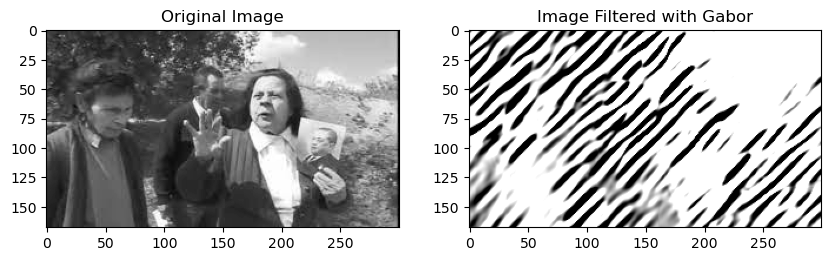

In [37]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Read the image in grayscale
img = cv.imread('lena.jpg', cv.IMREAD_GRAYSCALE)

# Check if the image was loaded
if img is None:
    print("Error: Image not found")
    exit()

# Define Gabor filter parameters
ksize = 31
sigma = 5.0
theta = np.pi / 4
lambd = 10.0
gamma = 0.5
psi = 0

# Create the Gabor kernel
kernel = cv.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi)

# Apply the Gabor filter to the image
filtered_image = cv.filter2D(img, cv.CV_8U, kernel)

# Normalize the output for visualization
filtered_image_normalized = cv.normalize(filtered_image, None, 0, 255, cv.NORM_MINMAX, dtype=cv.CV_8U)

# Show the original image and the filtered image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1), plt.imshow(img, cmap="gray"), plt.title("Original Image")
plt.subplot(1, 2, 2), plt.imshow(filtered_image_normalized, cmap="gray"), plt.title("Image Filtered with Gabor")
plt.show()


**HOG descriptor**

In [38]:
#See documentation
help(cv.HOGDescriptor)

Help on class HOGDescriptor in module cv2:

class HOGDescriptor(builtins.object)
 |  Methods defined here:
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __repr__(self, /)
 |      Return repr(self).
 |  
 |  checkDetectorSize(...)
 |      checkDetectorSize() -> retval
 |      .   @brief Checks if detector size equal to descriptor size.
 |  
 |  compute(...)
 |      compute(img[, winStride[, padding[, locations]]]) -> descriptors
 |      .   @brief Computes HOG descriptors of given image.
 |      .       @param img Matrix of the type CV_8U containing an image where HOG features will be calculated.
 |      .       @param descriptors Matrix of the type CV_32F
 |      .       @param winStride Window stride. It must be a multiple of block stride.
 |      .       @param padding Padding
 |      .       @param locations Vector of Point
 |  
 |  computeGradient(...)
 |      computeGradient(img, grad, angleOfs[, padding

In [44]:
#Default parameters:
hog = cv.HOGDescriptor() # Equivalent to: cv.HOGDescriptor((64, 128), (16, 16), (8, 8), (8, 8), 9)

It's important to note that, unlike the theoretical algorithm we've seen, the OpenCV implementation involves a window that moves across the entire image to compute HOG descriptors. The default window size is 64x128 pixels, meaning that objects to be detected should have at least that size. If working with smaller resolutions, this should be adjusted.

The default length of the HOG vector (which can be obtained using `hog.getDescriptorSize()`) is 3,780 elements per descriptor.

In [45]:
winStride = (0,0)
padding = (0,0)
locations = ()

descriptors = hog.compute(img, winStride, padding, locations)


The compute function stores the points where people are found in the image in the locations vector and the descriptor values for each point in the descriptors vector.

**Exercise 3:** Implement (completing TODO tags) a HUG descriptor using scikit library

In [46]:
!pip install scikit-image


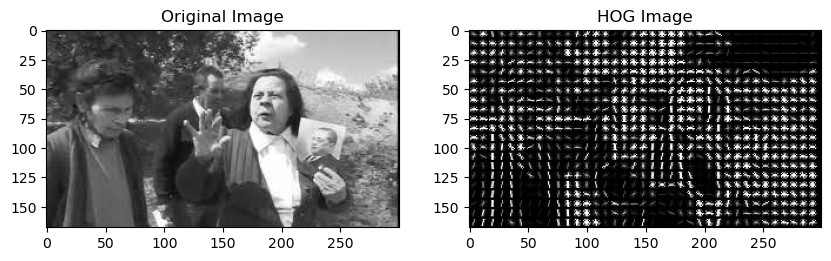

In [47]:
import cv2
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

# Read the image in grayscale
img = cv.imread('lena.jpg', cv.IMREAD_GRAYSCALE)

# Calculating HOG
features, hog_image = hog(img, visualize=True)

# Adjust the contrast of the image HOG
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# Show both images: original and HOG
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1), plt.imshow(img, cmap="gray"), plt.title("Original Image")
plt.subplot(1, 2, 2), plt.imshow(hog_image_rescaled, cmap="gray"), plt.title("HOG Image")

plt.show()

# Local feature extraction

**Exercise 3:** Implement and compare Harris Corner Detector and FAST algorithms

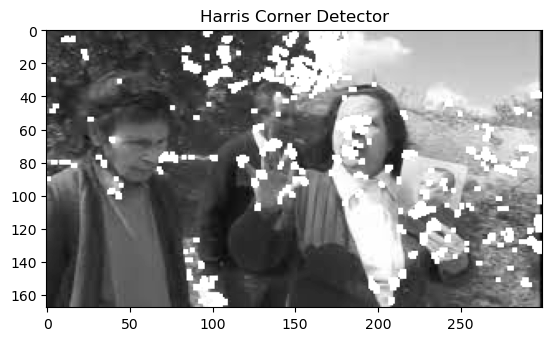

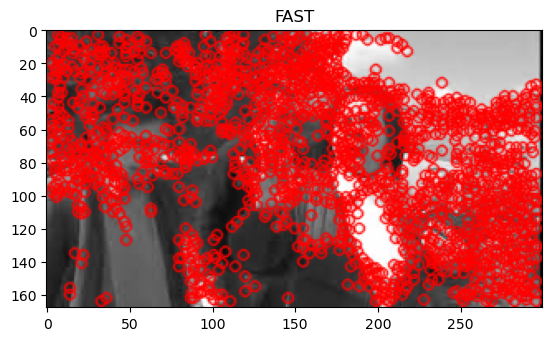

In [62]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Read the image
img = cv.imread('lena.jpg', cv.IMREAD_GRAYSCALE)

# Create a copy of the image for each algorithm
harris_img = img.copy()
fast_img = img.copy()

# Harris Corner Detector
harris_corners = cv.cornerHarris(img, blockSize=2, ksize=3, k=0.04)
harris_corners = cv.dilate(harris_corners, None)
harris_img[harris_corners > 0.01 * harris_corners.max()] = 255

# FAST (Features from Accelerated Segment Test)
fast = cv.FastFeatureDetector_create()
fast_keypoints = fast.detect(img, None)
fast_img = cv.drawKeypoints(img, fast_keypoints, None, color=(255, 0, 0))

# Display the images
plt.imshow(harris_img, cmap='gray')
plt.title('Harris Corner Detector')
plt.show()

plt.imshow(fast_img, cmap='gray')
plt.title('FAST')
plt.show()

**MSER**

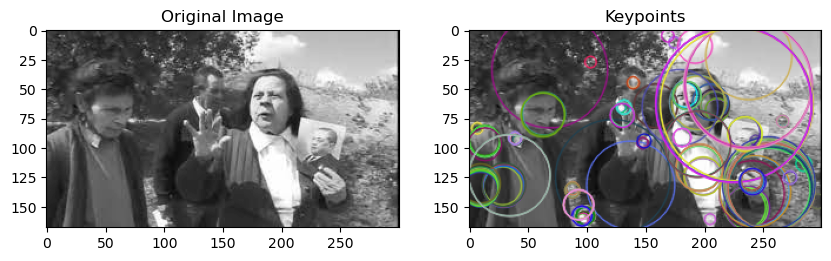

In [52]:
#MSER
import cv2 as cv
import argparse
import numpy as np

# Read the image in grayscale
image = cv.imread('lena.jpg', cv.IMREAD_GRAYSCALE)

# Create the detector
detector = cv.MSER_create()

# Apply the detector to obtain keypoints
keypoints = detector.detect(image, None)

# Draw the keypoints on the image. The last option is to show circles with their corresponding size.
output = cv.drawKeypoints(image, keypoints, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Visualize the result
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1), plt.imshow(image, cmap="gray"), plt.title("Original Image")
plt.subplot(1, 2, 2), plt.imshow(output, cmap="gray"), plt.title("Keypoints")

plt.show()

**SIFT**

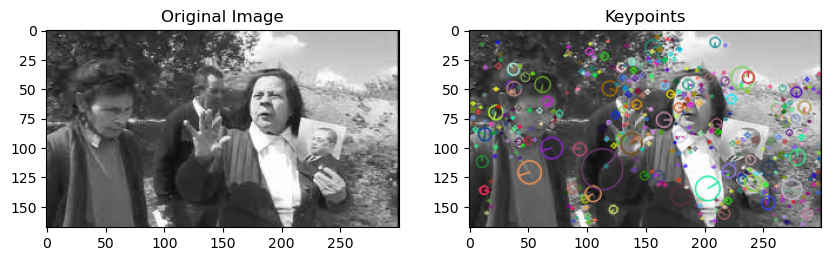

In [53]:
#SIFT
import cv2 as cv
import argparse
import numpy as np

# Read the image in grayscale
img = cv.imread('lena.jpg', cv.IMREAD_GRAYSCALE)

# Create the detector
detector = cv.SIFT_create()

# Apply the detector to obtain keypoints
keypoints = detector.detect(img, None)

# Draw the keypoints on the image. The last option is to show circles with their corresponding size.
output = cv.drawKeypoints(img, keypoints, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Visualize the result
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1), plt.imshow(img, cmap="gray"), plt.title("Original Image")
plt.subplot(1, 2, 2), plt.imshow(output, cmap="gray"), plt.title("Keypoints")

plt.show()

**ORB algorithm:**

Example: ORB as both detector and descriptor. In this code, we compare binary descriptors using Hamming distance. The matches returned by the `match` method in the `matches` variable are the pairs of most similar points between the first and second image.

Number of matches found: 28


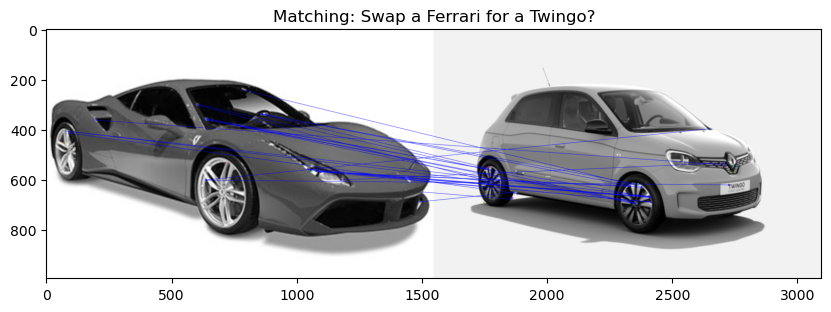

In [54]:
import cv2 as cv
import argparse
import numpy as np

# Read the image in grayscale
image1 = cv.imread('ferrari.jpg', cv.IMREAD_GRAYSCALE)
image2 = cv.imread('twingo.jpg', cv.IMREAD_GRAYSCALE)

#Scale image
image1 = cv.resize(image1, (1548, 994))


# Create the ORB detector with a maximum of 100 points
orb = cv.ORB_create(100)

# Use ORB to detect keypoints and compute descriptors
keypoints1, descriptors1 = orb.detectAndCompute(image1, None)
keypoints2, descriptors2 = orb.detectAndCompute(image2, None)

# Create the matcher and apply it
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)
print('Number of matches found:', len(matches))

# Draw the result
imageMatches = cv.drawMatches(image1, keypoints1, image2, keypoints2, matches, (0, 0, 255), (0, 0, 255))
plt.figure(figsize=(10, 5))
plt.imshow(imageMatches, cmap="gray"), plt.title("Matching: Swap a Ferrari for a Twingo?")

plt.show()



In this case, we used the `detectAndCompute` method, but `detect` and `compute` can also be used separately.

Similar to the previous example, we can replace ORB with SIFT to obtain matches with that descriptor. However, the comparator cannot be `NORM_HAMMING` but, for example, `NORM_L2` (Euclidean distance).

If there are many matching points (e.g., if we don't limit to 100 keypoints per image), we typically want to keep only the best ones. For this, we can sort the matches from smallest to largest distance as follows:


In [55]:
matches = sorted(matches, key=lambda x: x.distance)
# Keep the 50 most similar points
imageMatches = cv.drawMatches(image1, keypoints1, image2, keypoints2, matches[:50], image2, flags=2)

**Exercise 4:** Change the previous code with SIFT

Number of matches found: 191


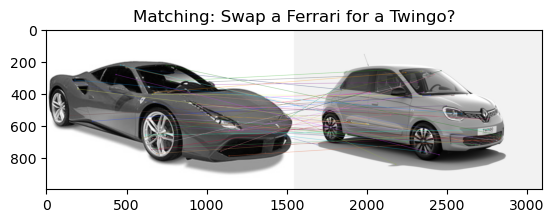

In [58]:
sift = cv.SIFT_create()

# Use SIFT to detect keypoints and compute descriptors
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

# Create the matcher and apply it
bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)
print('Number of matches found:', len(matches))

# Sort the matches by distance
matches = sorted(matches, key=lambda x: x.distance)

# Keep the 50 most similar points
imageMatches = cv.drawMatches(image1, keypoints1, image2, keypoints2, matches[:50], image2, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

import matplotlib.pyplot as plt

plt.imshow(imageMatches)
plt.title("Matching: Swap a Ferrari for a Twingo?")
plt.show()
